In [ ]:
def load_yolo_labels(label_path):
    """
    Load YOLO format labels from the given path.

    Parameters:
    label_path: str
        Path to the label file.

    Returns:
    list of tuples
        List of bounding boxes (class_id, center_x, center_y, width, height).
    """
    with open(label_path, 'r') as file:
        labels = []
        for line in file:
            class_id, center_x, center_y, width, height = map(float, line.strip().split())
            labels.append((int(class_id), center_x, center_y, width, height))
        return labels

In [ ]:
from PIL import Image
import cv2
import numpy as np

def annotate_image(img, yolo_bbox):
    """
    Annotate the image with the bounding boxes of the detected objects.

    Parameters:
    img: PIL.Image
        The image to annotate.
    yolo_bbox: list of tuples
        List of YOLO format bounding boxes (class_id, center_x, center_y, width, height).

    Returns:
    PIL.Image
        The annotated image.
    """
    img = np.array(img)
    height, width, _ = img.shape
    
    for bbox in yolo_bbox:
        class_id, center_x, center_y, bbox_width, bbox_height = bbox
        
        # Convert YOLO format to corner coordinates
        x1 = int((center_x - bbox_width / 2) * width)
        y1 = int((center_y - bbox_height / 2) * height)
        x2 = int((center_x + bbox_width / 2) * width)
        y2 = int((center_y + bbox_height / 2) * height)
        
        # Draw rectangle around detected object
        color = (0, 255, 0)  # Green color for bounding box
        thickness = 2  # Thickness of bounding box lines
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        
        # Optionally, add the class ID or label
        if class_id == 0: 
            state = "[CLOSED]"
        elif class_id == 1: 
            state = "[SEMI-OPEN]"
        elif class_id == 2: 
            state = "[OPEN]"
        else:
            return Image.fromarray(img)
        label = f"Refuelling Port {state}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > 10 else y1 + 10
        cv2.rectangle(img, (label_x, label_y - label_size[1]), 
                      (label_x + label_size[0], label_y + label_size[1]), color, -1)
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return Image.fromarray(img)


### Generate a images grid 

In [15]:
import random
import os
from PIL import Image

from torchvision.utils import make_grid, save_image
import torchvision.transforms.functional as TF

#folder_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/data/frames/full_dataset_annotated_YOLO/close/train/all"
grid_size = 3

images_folder_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/data/AGR_Dataset/ORIG/visible"
#labels_folder_path = folder_path + "/labels"

images = []
for i in range(grid_size * grid_size):
    image_file = random.choice(os.listdir(images_folder_path))
    image_path = os.path.join(images_folder_path, image_file)
    #label_path = os.path.join(labels_folder_path, os.path.splitext(image_file)[0] + '.txt')
    
    image = Image.open(image_path)

    # Resize the image to 256x256
    image = image.resize((256, 256))

    #labels = load_yolo_labels(label_path)
    #annotated_image = annotate_image(image, labels)
    
    # Transform the annotated image to tensor
    image_tensor = TF.to_tensor(image)
    images.append(image_tensor)

# Create a grid of images
grid_image = make_grid(images, nrow=grid_size)
save_image(grid_image, "AGRDatasetGrid.png")

### Visualize the movements accross frames

In [1]:
def load_json(path: str) -> dict:
    with open(path, "r") as file:
        return json.load(file)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

test_data_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/data/frames/full_dataset_annotated_fpp/test.json"
test_filtered_sma_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/data/frames/full_dataset_annotated_fpp/test_filter_sma.json"
test_filtered_gaussian_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/data/frames/full_dataset_annotated_fpp/test_filter_gaussian.json"
test_filtered_savgol_path = "/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/data/frames/full_dataset_annotated_fpp/test_filter_savgol.json"

# Load the JSON data
raw_data = load_json(test_data_path)
data_filtered_sma = load_json(test_filtered_sma_path)
data_filtered_gaussian = load_json(test_filtered_gaussian_path)
data_filtered_savgol = load_json(test_filtered_savgol_path)

# Select a random video ID
video_ids = list(set(entry['video_id'] for entry in raw_data))

In [3]:
video_ids 

['test_indoor1',
 'video_lab_semiopen_1______3',
 'test_outdoor1',
 'video_lab_platform_6']

In [57]:
video_id = video_ids[3]

In [37]:
def return_video_data(data, video_id) -> tuple:
    selected_bbox_data = []
    for entry in data:
        if entry["video_id"] == video_id:
            for frame in entry["frames"]:
                bbox = frame["bbox"]
                bbox = [0 if coord is None else coord for coord in bbox]
                selected_bbox_data.append((frame["frame_id"], bbox))

    # Sort the data by frame_id
    selected_bbox_data = sorted(selected_bbox_data, key=lambda x: x[0])

    # Convert to numpy array for easier manipulation
    frame_ids, bboxes = zip(*selected_bbox_data)
    bbox_array = np.array(bboxes)

    # Calculate velocity and acceleration
    velocities = np.diff(bbox_array, axis=0)
    accelerations = np.diff(velocities, axis=0)

    # Insert zeros for the first frame's velocity and acceleration
    velocities = np.vstack(([0, 0, 0, 0], velocities))
    accelerations = np.vstack(([0, 0, 0, 0], [0, 0, 0, 0], accelerations))

    return (frame_ids, bbox_array, velocities, accelerations)

In [58]:
raw_data_frame_ids, raw_data_bboxes, raw_data_velocities, raw_data_accelerations = return_video_data(raw_data, video_id)
data_filtered_gaussian_frame_ids, data_filtered_gaussian_bboxes, data_filtered_gaussian_velocities, data_filtered_gaussian_accelerations = return_video_data(data_filtered_gaussian, video_id)
data_filtered_sma_frame_ids, data_filtered_sma_bboxes, data_filtered_sma_velocities, data_filtered_sma_accelerations = return_video_data(data_filtered_sma, video_id)
data_filtered_savgol_frame_ids, data_filtered_savgol_bboxes, data_filtered_savgol_velocities, data_filtered_savgol_accelerations = return_video_data(data_filtered_savgol, video_id)

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_central_position(
    video_id, frame_indices, x_center, y_center, folder_save_path
):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_center, label="X Center")
    plt.plot(frame_indices, y_center, label="Y Center")
    plt.title(f"Central Position of Bounding Box over Time for video {video_id}")
    plt.xlabel("Frame")
    plt.ylabel("Normalized Coordinate")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_central_position.png")
    plt.savefig(save_path)

    plt.show()


def plot_velocity(video_id, frame_indices, x_velocity, y_velocity, folder_save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_velocity, label="X Velocity", color="red")
    plt.plot(frame_indices, y_velocity, label="Y Velocity", color="green")
    plt.title(f"Velocity of Bounding Box over Time for video {video_id}")
    plt.xlabel("Frame")
    plt.ylabel("Velocity")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_velocity.png")
    plt.savefig(save_path)

    plt.show()


def plot_acceleration(
    video_id, frame_indices, x_acceleration, y_acceleration, folder_save_path
):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, x_acceleration, label="X Acceleration", color="red")
    plt.plot(frame_indices, y_acceleration, label="Y Acceleration", color="green")
    plt.title(f"Acceleration of Bounding Box over Time for video {video_id}")
    plt.xlabel("Frame")
    plt.ylabel("Acceleration")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_acceleration.png")
    plt.savefig(save_path)

    plt.show()


def plot_area(video_id, frame_indices, area, folder_save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, area, label="Area", color="green")
    plt.title(f"Area of Bounding Box over Time for video {video_id}")
    plt.xlabel("Frame")
    plt.ylabel("Area")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_area.png")
    plt.savefig(save_path)

    plt.show()


def plot_aspect_ratio(video_id, frame_indices, aspect_ratio, folder_save_path):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, aspect_ratio, label="Aspect Ratio", color="red")
    plt.title(f"Aspect Ratio of Bounding Box over Time for video {video_id}")
    plt.xlabel("Frame")
    plt.ylabel("Aspect Ratio")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    save_path = os.path.join(folder_save_path, f"{video_id}_aspect_ratio.png")
    plt.savefig(save_path)

    plt.show()


def plot_bounding_box_metrics(
    video_id,
    bbox_array,
    folder_save_path="/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/report/figures/bbox_metrics",
):
    # Calculate central position, area, and aspect ratio
    x_center = bbox_array[:, 0] + 0.5 * bbox_array[:, 2]
    y_center = bbox_array[:, 1] + 0.5 * bbox_array[:, 3]
    area = bbox_array[:, 2] * bbox_array[:, 3]
    aspect_ratio = bbox_array[:, 2] / bbox_array[:, 3]

    # Time or frame indices
    frame_indices = np.arange(len(bbox_array))

    # Calculate velocity
    x_velocity = np.diff(x_center, prepend=x_center[0])
    y_velocity = np.diff(y_center, prepend=y_center[0])
    velocity_magnitude = np.sqrt(x_velocity**2 + y_velocity**2)

    # Calculate acceleration
    x_acceleration = np.diff(x_velocity, prepend=x_velocity[0])
    y_acceleration = np.diff(y_velocity, prepend=y_velocity[0])
    acceleration_magnitude = np.sqrt(x_acceleration**2 + y_acceleration**2)

    # Plot each metric in a separate figure
    plot_central_position(video_id, frame_indices, x_center, y_center, folder_save_path)
    plot_velocity(video_id, frame_indices, x_velocity, y_velocity, folder_save_path)
    plot_acceleration(
        video_id, frame_indices, x_acceleration, y_acceleration, folder_save_path
    )
    plot_area(video_id, frame_indices, area, folder_save_path)
    plot_aspect_ratio(video_id, frame_indices, aspect_ratio, folder_save_path)

/var/folders/dl/8q6wl_5d3xg5j5ynz7vqlq_c0000gn/T/ipykernel_93922/3820936450.py:102: RuntimeWarning: invalid value encountered in divide
  aspect_ratio = bbox_array[:, 2] / bbox_array[:, 3]


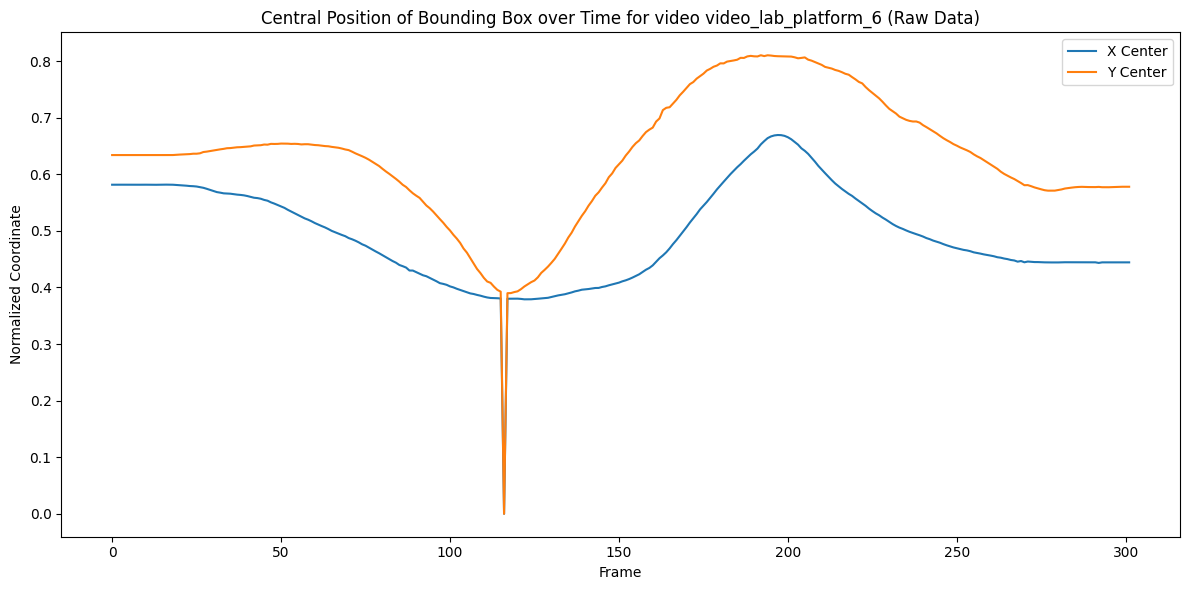

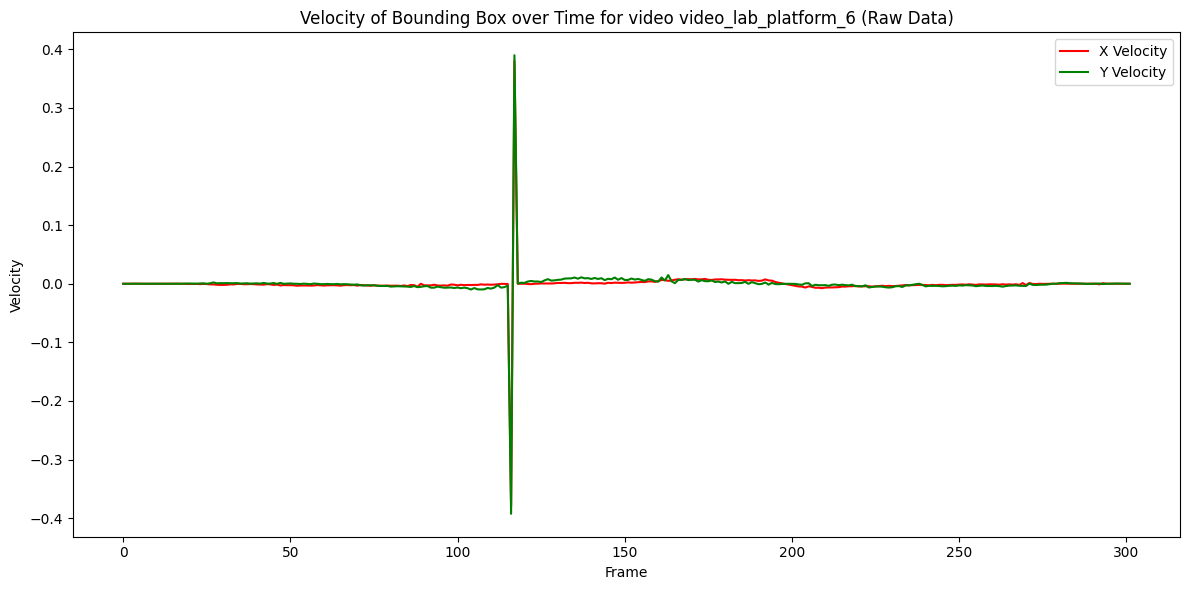

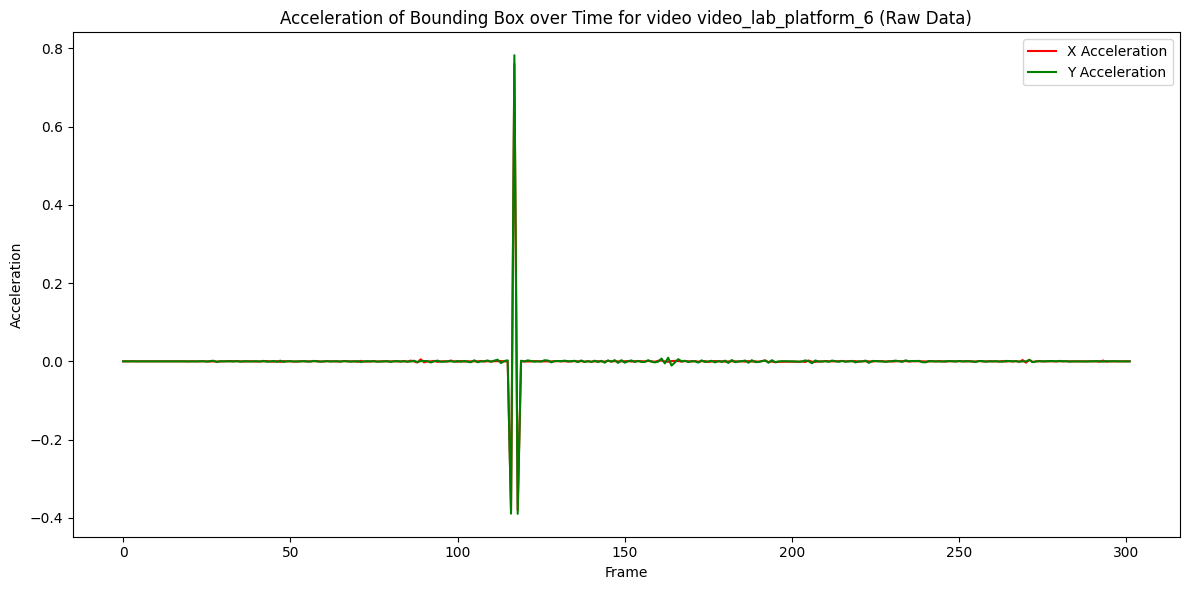

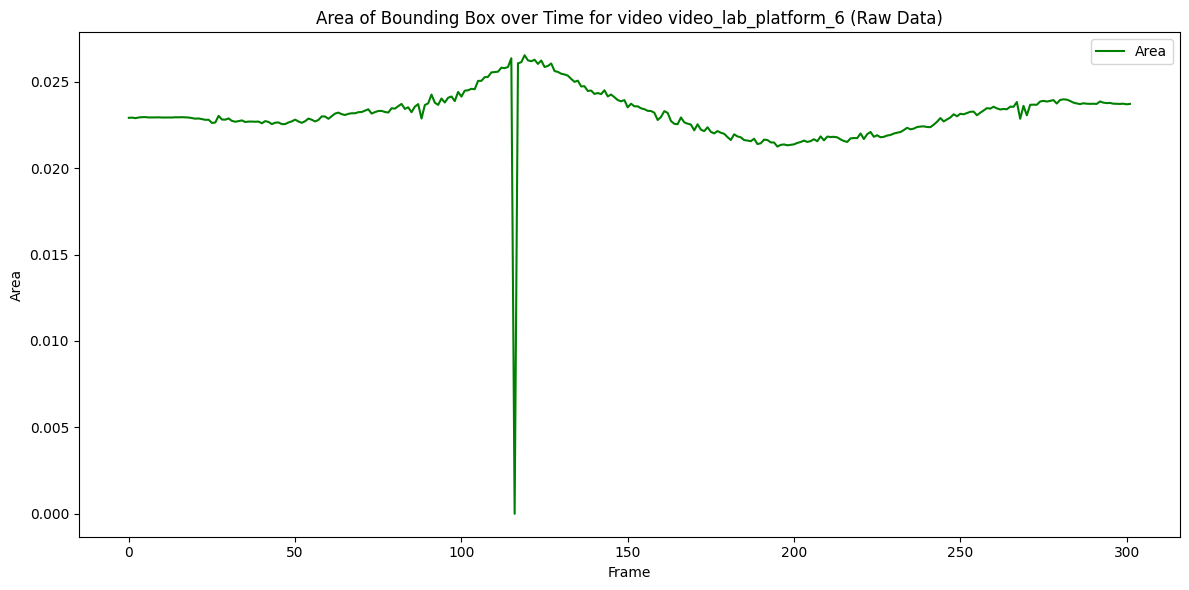

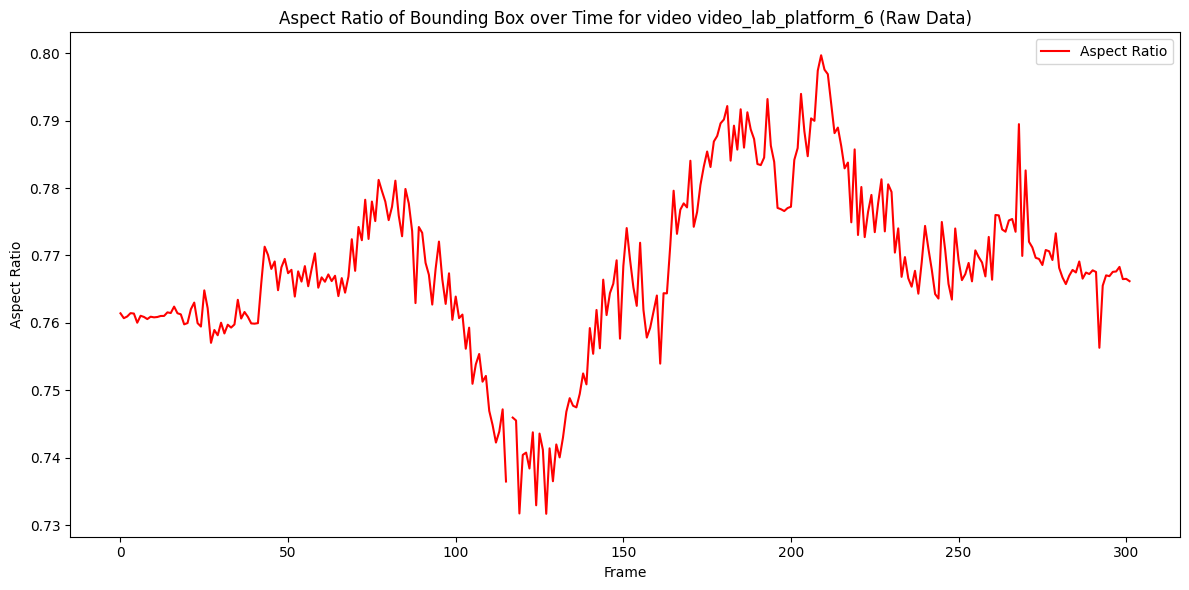

In [59]:
video_id_modified = video_id + " (Raw Data)"
plot_bounding_box_metrics(video_id_modified, raw_data_bboxes)

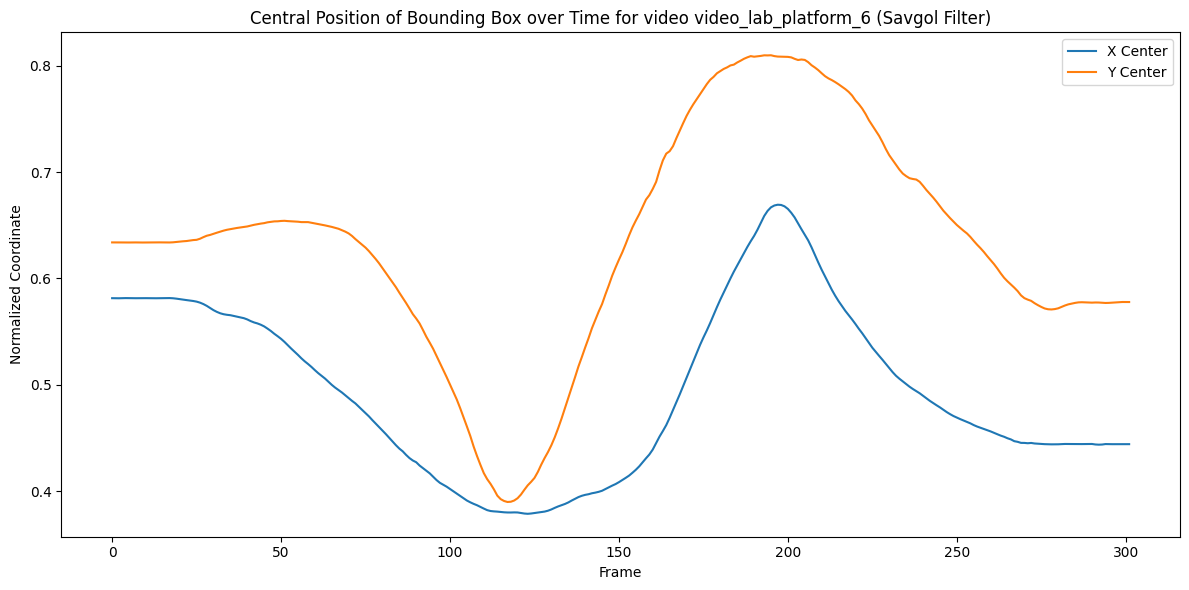

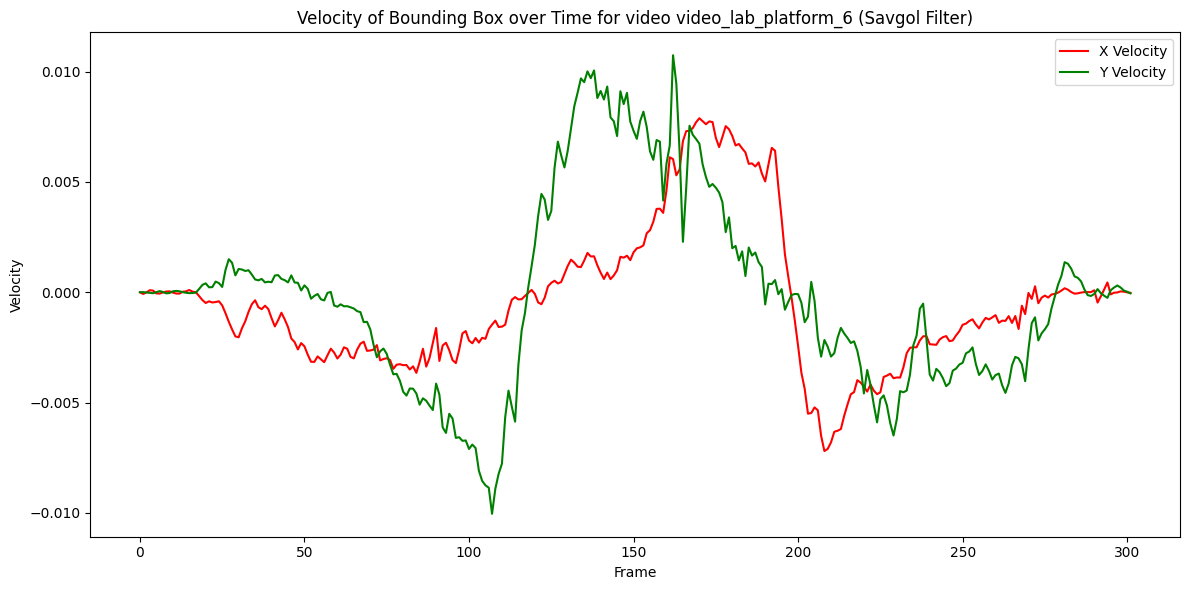

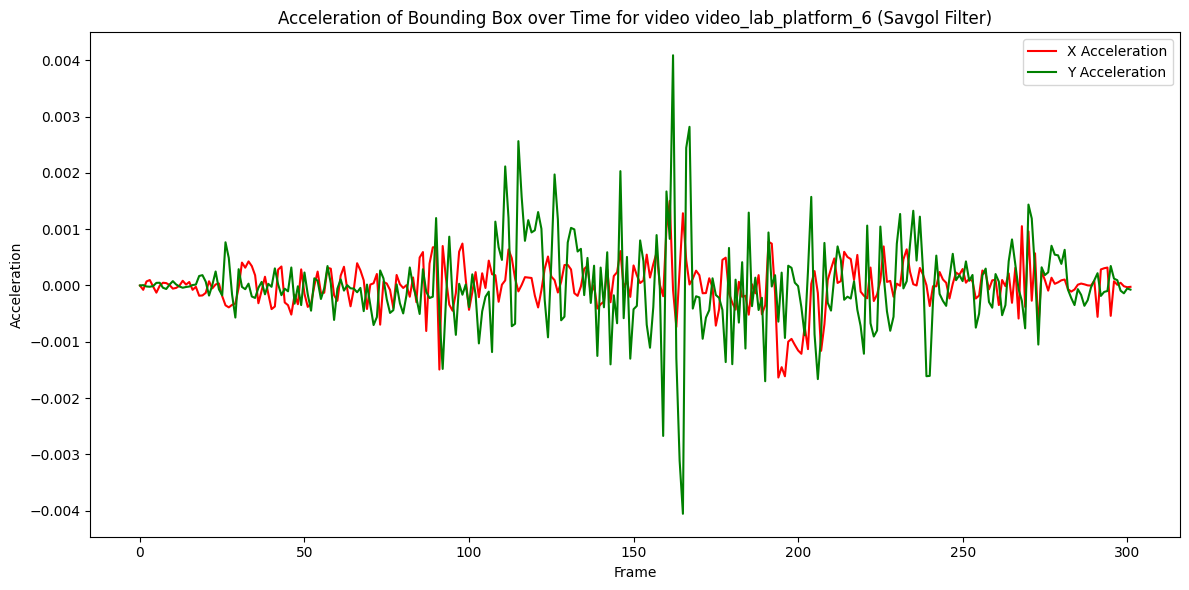

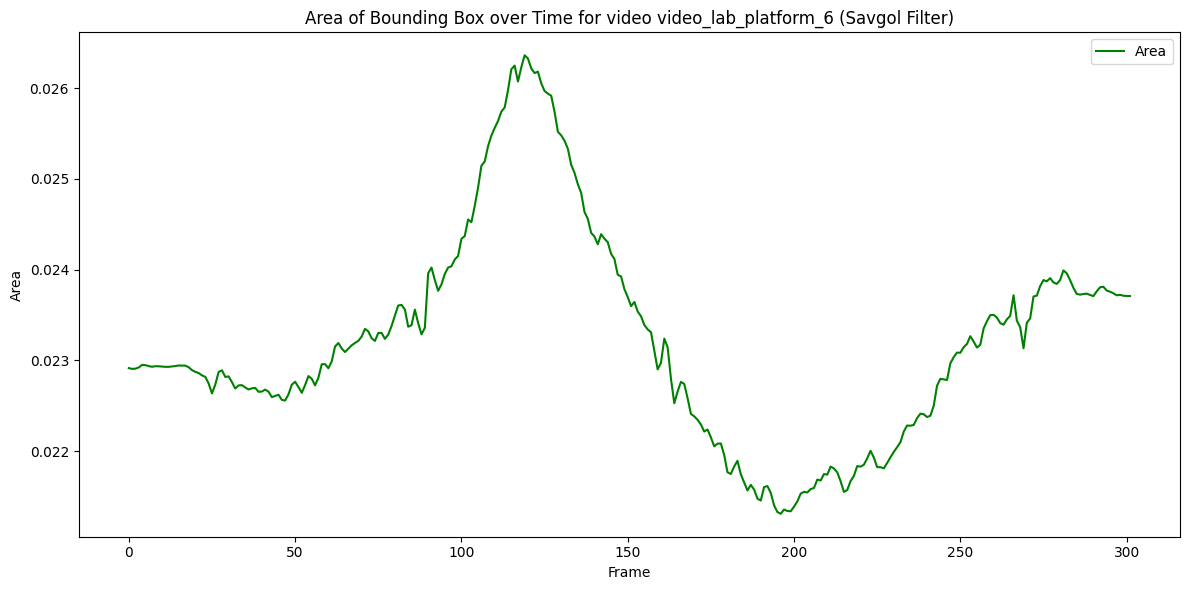

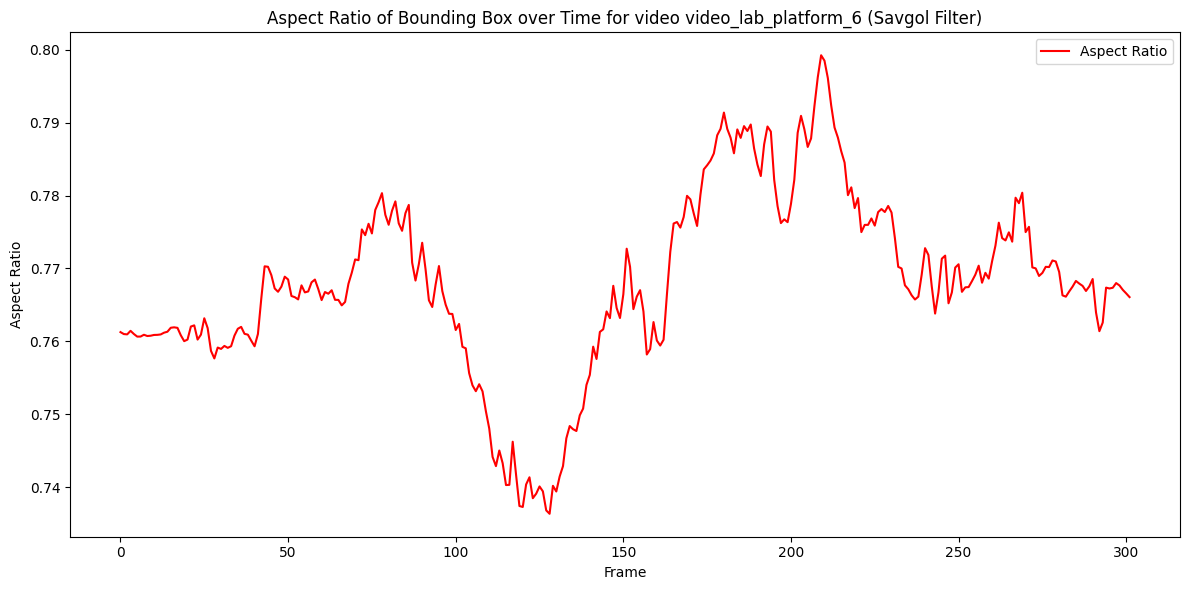

In [60]:
modified_video_id = video_id + " (Savgol Filter)"
plot_bounding_box_metrics(modified_video_id, data_filtered_savgol_bboxes)

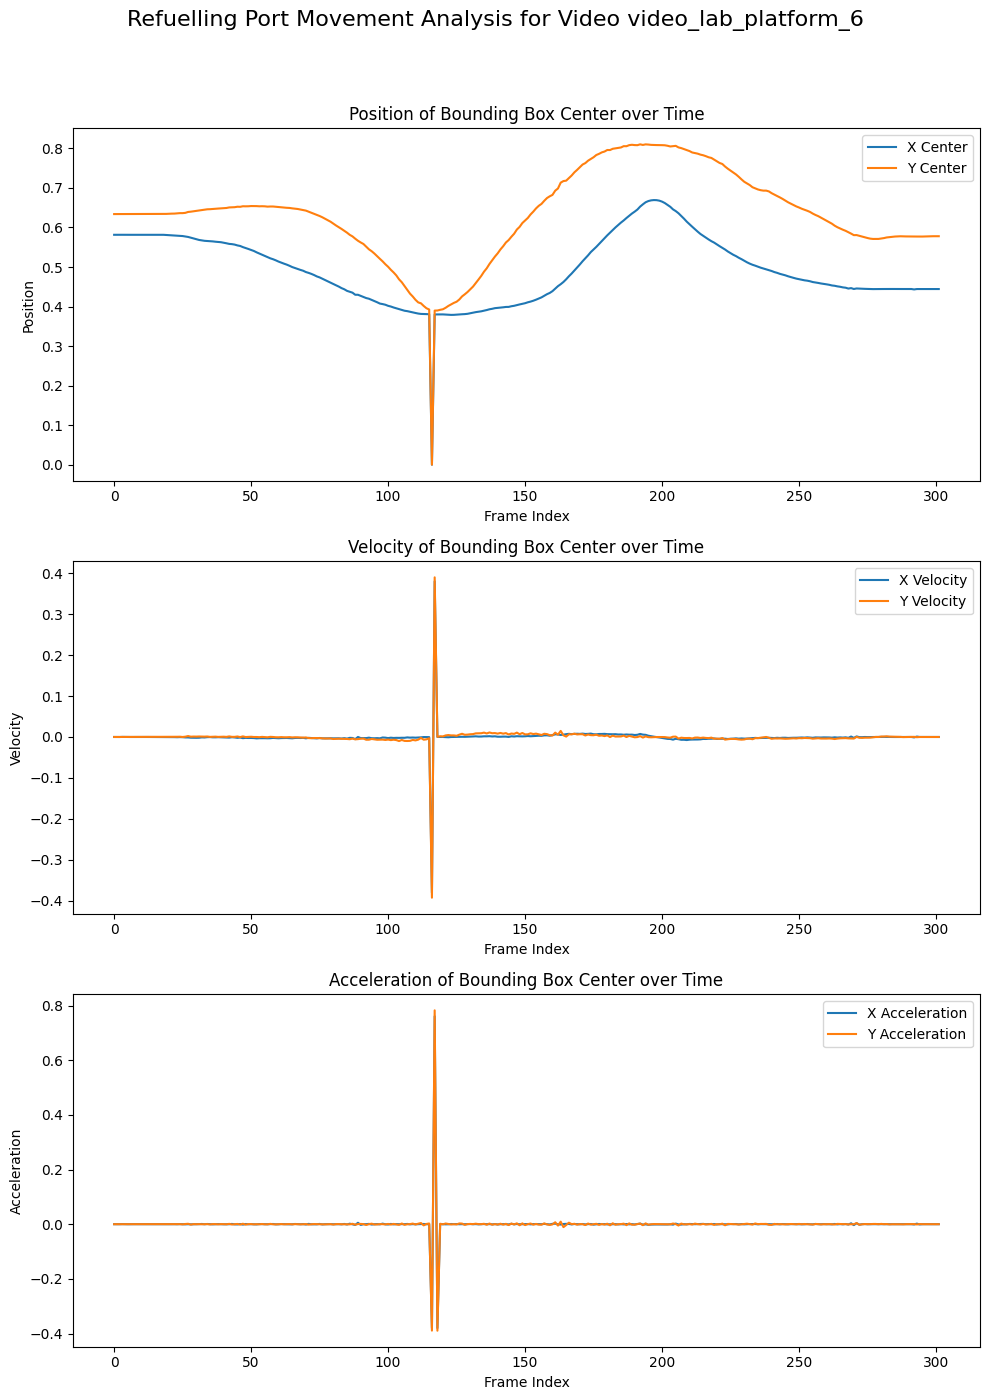

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate velocity
x_velocity = np.diff(x_center, prepend=x_center[0])
y_velocity = np.diff(y_center, prepend=y_center[0])
velocity_magnitude = np.sqrt(x_velocity**2 + y_velocity**2)

# Calculate acceleration
x_acceleration = np.diff(x_velocity, prepend=x_velocity[0])
y_acceleration = np.diff(y_velocity, prepend=y_velocity[0])
acceleration_magnitude = np.sqrt(x_acceleration**2 + y_acceleration**2)

# Time or frame indices
frame_indices = np.arange(len(x_center))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Set Title 
fig.suptitle(
    f"Refuelling Port Movement Analysis for Video {video_id}",
    fontsize=16,
)

# Position Plot
axs[0].plot(frame_indices, x_center, label="X Center")
axs[0].plot(frame_indices, y_center, label="Y Center")
axs[0].set_title("Position of Bounding Box Center over Time")
axs[0].set_xlabel("Frame Index")
axs[0].set_ylabel("Position")
axs[0].legend()

# Velocity Plot
axs[1].plot(frame_indices, x_velocity, label="X Velocity")
axs[1].plot(frame_indices, y_velocity, label="Y Velocity")
axs[1].set_title("Velocity of Bounding Box Center over Time")
axs[1].set_xlabel("Frame Index")
axs[1].set_ylabel("Velocity")
axs[1].legend()

# Acceleration Plot
axs[2].plot(frame_indices, x_acceleration, label="X Acceleration")
axs[2].plot(frame_indices, y_acceleration, label="Y Acceleration")
axs[2].set_title("Acceleration of Bounding Box Center over Time")
axs[2].set_xlabel("Frame Index")
axs[2].set_ylabel("Acceleration")
axs[2].legend()

# Add space between title and plots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data for x_center and y_center as placeholders
x_center = np.linspace(0, 10, 100)
y_center = np.sin(x_center)

# Calculate velocity: differences in position
x_velocity = np.diff(x_center, prepend=x_center[0])
y_velocity = np.diff(y_center, prepend=y_center[0])

# Calculate acceleration: differences in velocity
x_acceleration = np.diff(x_velocity, prepend=x_velocity[0])
y_acceleration = np.diff(y_velocity, prepend=y_velocity[0])

# Calculate magnitudes for velocity and acceleration for z-axis
velocity_magnitude = np.sqrt(x_velocity**2 + y_velocity**2)
acceleration_magnitude = np.sqrt(x_acceleration**2 + y_acceleration**2)
z_component = velocity_magnitude + acceleration_magnitude  # Combination of velocity and acceleration

# Setting up a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting trajectory in 3D
ax.plot(x_center, y_center, z_component, label='3D Trajectory with Velocity and Acceleration Magnitude')

# Adding labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Combined Velocity and Acceleration Magnitude')
ax.set_title('3D Trajectory of Object Movement')

# Adding legend
ax.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Recalculate pan, tilt, and zoom assuming x_center, y_center, and area are correct
pan = np.diff(x_center, prepend=x_center[0])
tilt = np.diff(y_center, prepend=y_center[0])
zoom = np.diff(area, prepend=area[0])

# Ensure all arrays are of the same length
# Normally they should be since diff and prepend are used, but let's align them just in case:
length = min(len(pan), len(tilt), len(zoom))
pan, tilt, zoom = pan[:length], tilt[:length], zoom[:length]

# Setting up a 3D plot for camera movement
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting pan (x changes), tilt (y changes), and zoom (area changes) to visualize camera movement
ax.plot(pan, tilt, zoom, label='Camera Movement (Pan, Tilt, Zoom)')
ax.scatter(pan, tilt, zoom, c=np.linspace(0, 1, len(pan)), cmap='viridis')  # Color by index for clarity

# Labeling the axes
ax.set_xlabel('Pan (x changes)')
ax.set_ylabel('Tilt (y changes)')
ax.set_zlabel('Zoom (Area changes)')

ax.set_title('3D Visualization of Camera Movement Around the Refueling Port')
ax.legend()

plt.show()

# Framework Results

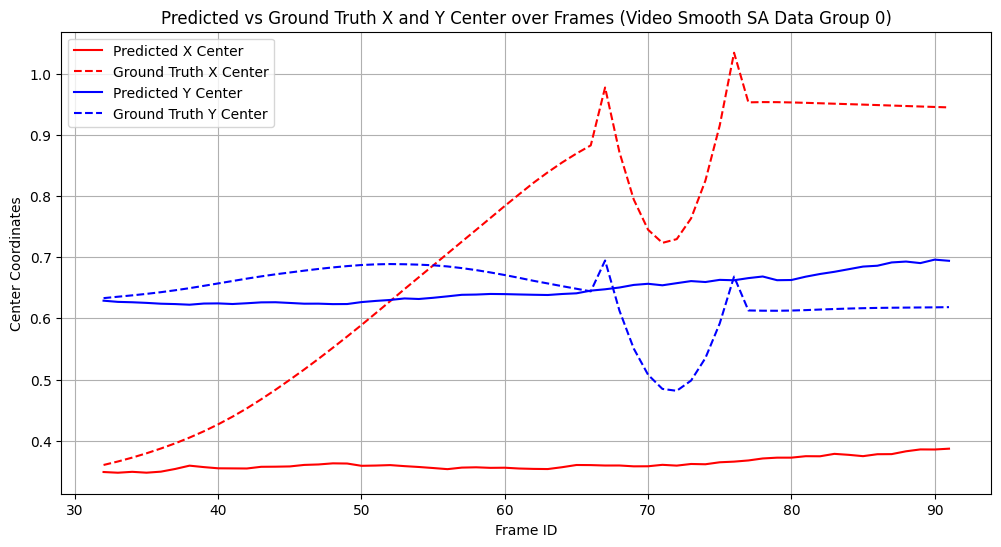

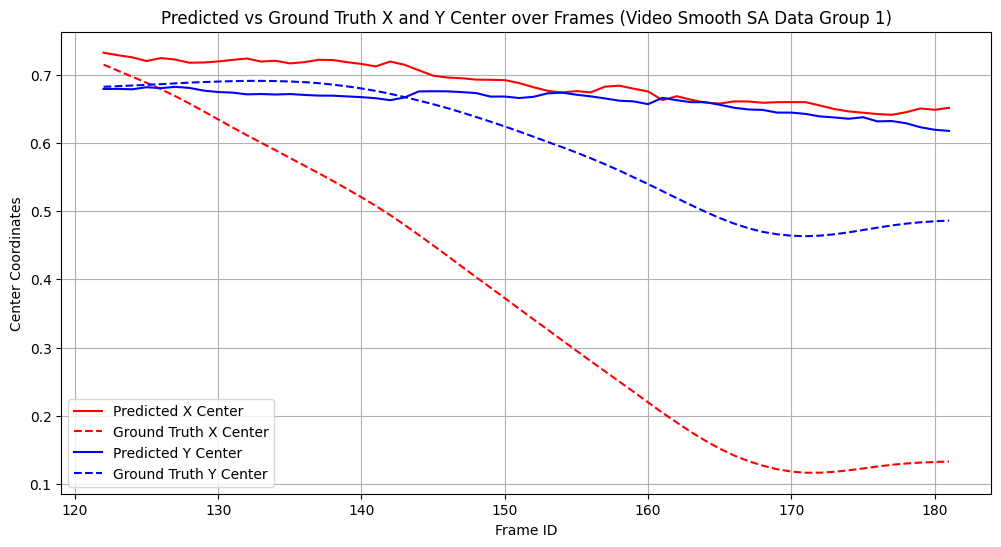

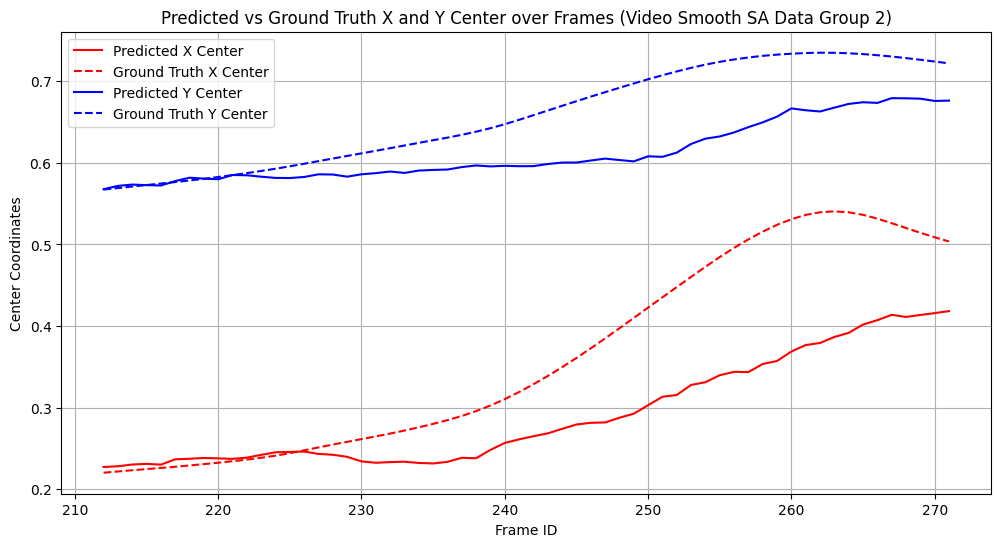

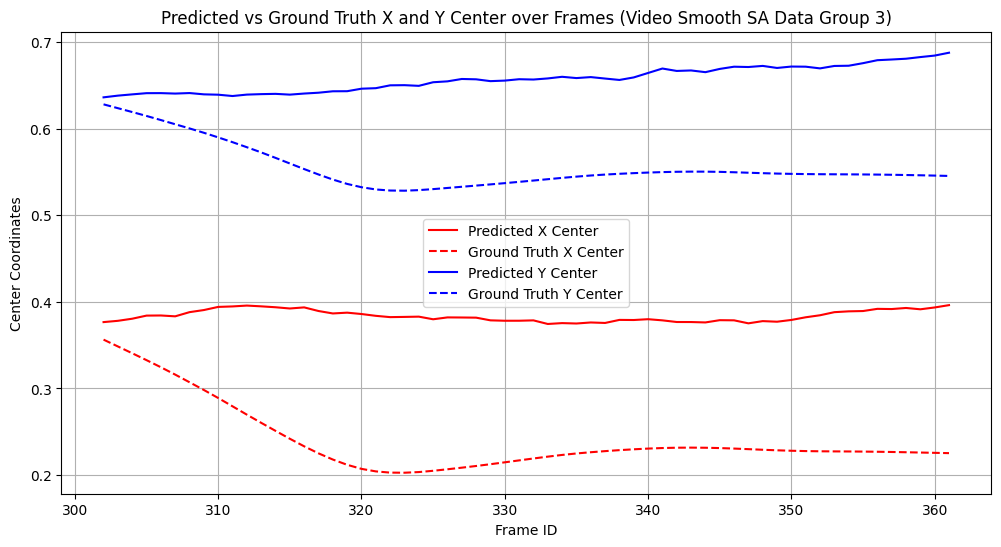

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt

def plot_trajectory(file_path, name):
    with open(file_path, 'r') as file:
        new_data = json.load(file)

    # Create lists to store x_center and y_center for predictions and ground truth
    new_frame_ids = []
    new_predicted_x_center = []
    new_predicted_y_center = []
    new_ground_truth_x_center = []
    new_ground_truth_y_center = []

    # Loop through the data and extract the relevant information
    for entry in new_data:
        if entry['ground_truth_position'] is not None:
            new_frame_ids.append(entry['frame_id'])
            new_predicted_x_center.append(entry['predicted_position']['x_center'])
            new_predicted_y_center.append(entry['predicted_position']['y_center'])
            new_ground_truth_x_center.append(entry['ground_truth_position']['x_center'])
            new_ground_truth_y_center.append(entry['ground_truth_position']['y_center'])

    # Create a DataFrame
    new_df = pd.DataFrame({
        'frame_id': new_frame_ids,
        'predicted_x_center': new_predicted_x_center,
        'predicted_y_center': new_predicted_y_center,
        'ground_truth_x_center': new_ground_truth_x_center,
        'ground_truth_y_center': new_ground_truth_y_center
    })

    # Identify the groups based on the gap of 30 frames
    new_df['group'] = (new_df['frame_id'].diff() > 30).cumsum()

    # Plotting separate graphs for each group
    new_groups = new_df['group'].unique()

    for group in new_groups:
        group_data = new_df[new_df['group'] == group]
        plt.figure(figsize=(12, 6))
        
        plt.plot(group_data['frame_id'], group_data['predicted_x_center'], label='Predicted X Center', linestyle='-', color='red')
        plt.plot(group_data['frame_id'], group_data['ground_truth_x_center'], label='Ground Truth X Center', linestyle='--', color='red')
        plt.plot(group_data['frame_id'], group_data['predicted_y_center'], label='Predicted Y Center', linestyle='-', color='blue')
        plt.plot(group_data['frame_id'], group_data['ground_truth_y_center'], label='Ground Truth Y Center', linestyle='--', color='blue')
        
        plt.xlabel('Frame ID')
        plt.ylabel('Center Coordinates')
        plt.title(f'Predicted vs Ground Truth X and Y Center over Frames (Video {name} Group {group})')
        plt.legend()
        plt.grid(True)
        
        # Save picture
        plt.savefig(f"{name} - {group}.png")
        
        plt.show()
        
        
plot_trajectory("/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/predictions_smooth_savideo_lab_semiopen_1______3.json", name="Smooth SA Data")

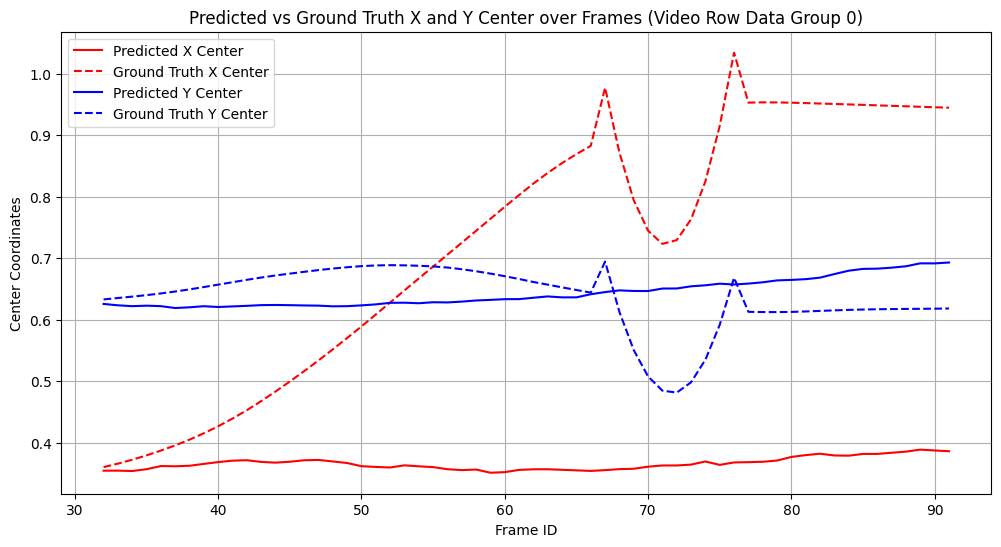

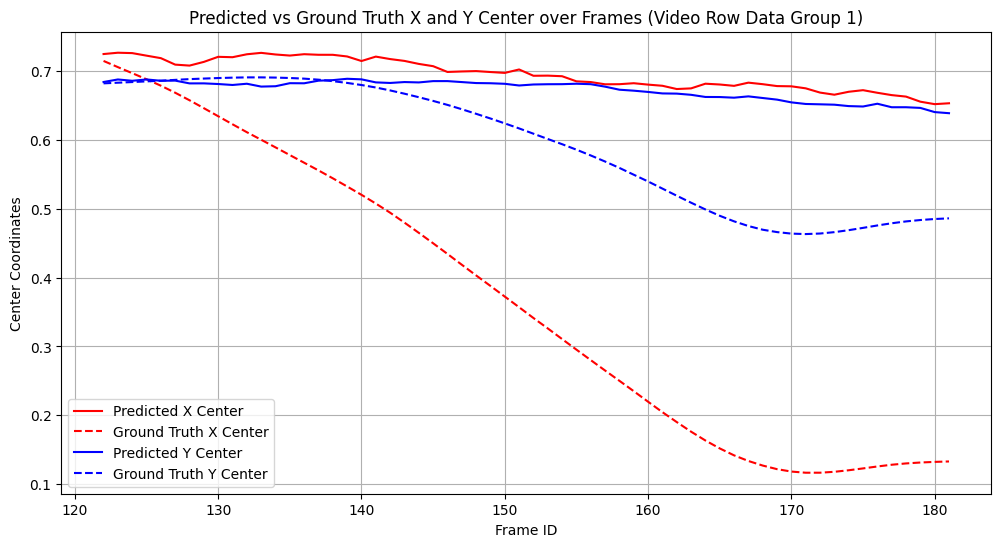

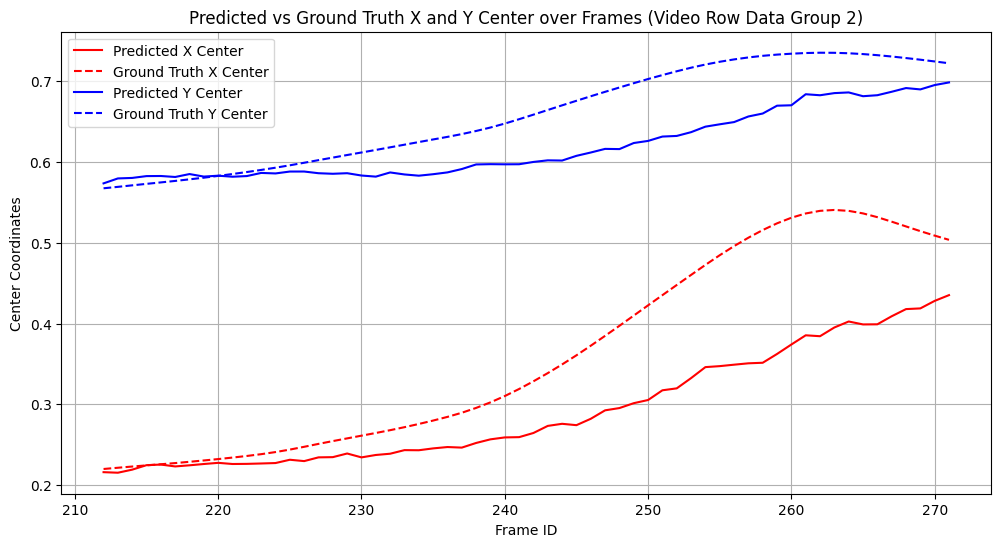

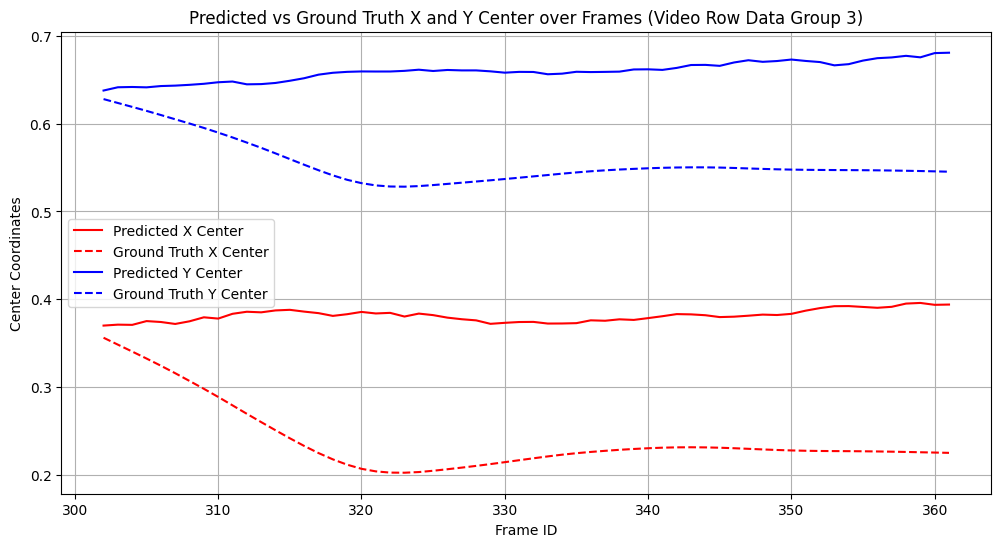

In [6]:
plot_trajectory("/Users/alexis/Library/CloudStorage/OneDrive-Balayre&Co/Cranfield/Thesis/thesis-github-repository/predictions_video_lab_semiopen_1______3.json", name="Row Data")